In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':16})

In [2]:
import sklearn.preprocessing

In [3]:
import numpy as np

In [4]:
import tensorflow as tf
import wispy.callbacks
import tensorflow_addons as tfa

In [5]:
import pycbc.types

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [6]:
from tf_fourier_features import FourierFeatureProjection

In [7]:
import utils

In [8]:
t1=-5000
t2=120
# t2=70
dt=0.5


# times_M = np.arange(-500, 120, 0.5)
# times_M = np.arange(-2000, 120, 0.5)
times_M = np.arange(t1,t2,dt)
# times_M = np.arange(-8000, 120, 0.5)
# times_M = np.arange(-8000*2, 120, 0.5)

In [9]:
8000/500

16.0

In [10]:
5000/500

10.0

In [11]:
data = utils.generate_waveform(times_M, mass_ratio=4, spin1z=0.99, f_lower=10, approximant="SEOBNRv4_opt")

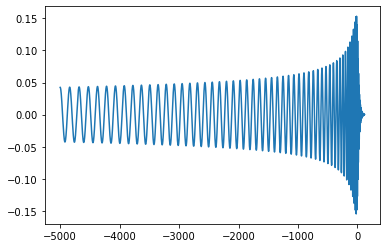

In [12]:
plt.plot(times_M, data['hp'])

In [13]:
target = 'hp'
# target = 'amp'
# target = 'phase'

In [14]:
X = times_M[:,np.newaxis]
y = data[target][:,np.newaxis]

In [15]:
X_idxs = np.arange(len(X))
X_training_idxs = X_idxs[::2]
X_validation_idxs = X_idxs[1::2]

In [16]:
X_train = X[X_training_idxs]
y_train = y[X_training_idxs]

X_val = X[X_validation_idxs]
y_val = y[X_validation_idxs]

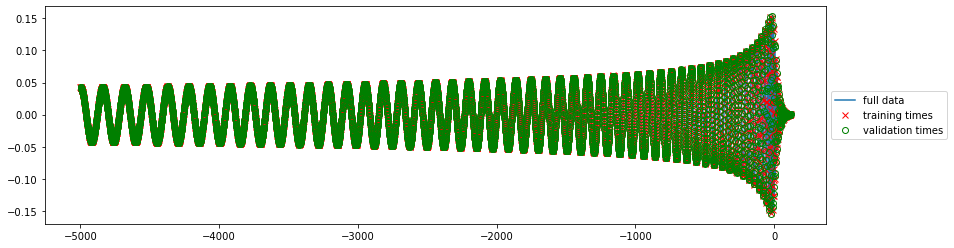

In [17]:
plt.figure(figsize=(14, 4))
plt.plot(X, y, label='full data')
plt.plot(X_train, y_train, 'rx', label='training times')
plt.plot(X_val, y_val, 'go',markerfacecolor='none', label='validation times')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

(-100.0, 100.0)

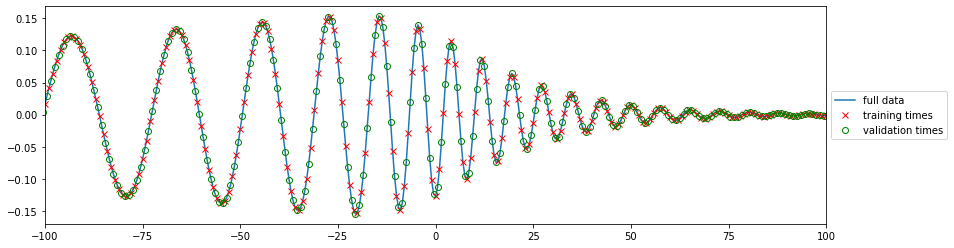

In [18]:
plt.figure(figsize=(14, 4))
plt.plot(X, y, label='full data')
plt.plot(X_train, y_train, 'rx', label='training times')
plt.plot(X_val, y_val, 'go',markerfacecolor='none', label='validation times')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(-100, 100)

In [19]:
feature_range=(-0.5, 0.5)
# feature_range=(0, 1)
# feature_range=(-1, 0)
X_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=feature_range)
X_train_scaled = X_scaler.fit_transform(X_train)
X_val_scaled = X_scaler.transform(X_val)

X_scaled = X_scaler.transform(X)


In [20]:
y_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=feature_range)
y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled = y_scaler.transform(y_val)

y_scaled = y_scaler.transform(y)

In [21]:
X_train_scaled.shape

(5120, 1)

In [22]:
# get frequency from X(_scaled),y(_scaled)

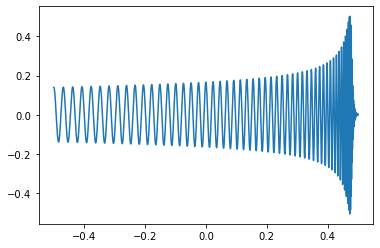

In [23]:
plt.plot(X_scaled, y_scaled)

In [24]:
ts_scaled = pycbc.types.TimeSeries(y_scaled[:,0], delta_t=X_scaled[1]-X_scaled[0])

In [25]:
fs_scaled = ts_scaled.to_frequencyseries()

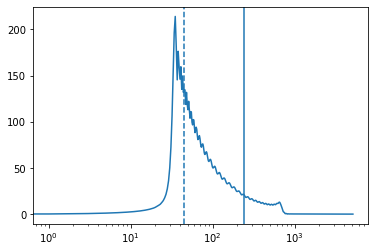

In [26]:
plt.plot(fs_scaled.sample_frequencies, np.abs(fs_scaled))
plt.xscale('log')
plt.axvline(45, ls='--')
plt.axvline(15*16)

In [27]:
np.argmax(np.abs(fs_scaled))

35

In [28]:
fs_scaled.sample_frequencies[np.argmax(np.abs(fs_scaled))]

34.99316406252493

In [143]:
def compile_model(model_version,
                  learning_rate=1e-3,
                  activation='relu',
                  units=256,
                  n_layers=3,
                  gaussian_projection=16,
                  gaussian_scale=5):

    inputs = tf.keras.Input(shape=(1,))
    
    if model_version == "RFF":
        x = FourierFeatureProjection(gaussian_projection = gaussian_projection, gaussian_scale = gaussian_scale)(inputs)
        x = tf.keras.layers.Dense(units, activation)(x)
    elif model_version == "dense":
        x = tf.keras.layers.Dense(units, activation)(inputs)
    else:
        raise ValueError()

    for i in range(n_layers-1):
        x = tf.keras.layers.Dense(units, activation)(x)
        # x = tf.keras.layers.LayerNormalization()(x)
    outputs = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate))
    return model

def fit_model(model, X_train, y_train, epochs, verbose, batch_size, validation_data, initial_epoch=0, callbacks=None):
    history = model.fit(x=X_train, y=y_train, epochs=epochs, verbose=verbose, batch_size=batch_size, callbacks=callbacks, validation_data=validation_data, initial_epoch=initial_epoch)
    return history, model

In [144]:
# 80000
# 50*4

In [145]:
100/6

16.666666666666668

In [146]:
16*16

256

In [147]:
model = compile_model(model_version="RFF",
                  learning_rate=1e-3,
                  activation='relu',
                  units=256,
                  n_layers=3,
                  gaussian_projection=16,
                  gaussian_scale=160)

In [148]:
epochs=100
# batch_size=32
# batch_size=512
batch_size=1024
# batch_size=2048
validation_data=(X_val_scaled, y_val_scaled)
learning_rate=1e-3
verbose=1
threshold=1e-8

In [149]:
# callbacks = [
#     tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
    # wispy.callbacks.ThresholdCallback(threshold),
    # tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=1000, factor=0.1, monitor='val_loss'),
    # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=300, restore_best_weights=True),
# ]
callbacks=None

In [150]:
fit_params=dict(
    X_train=X_train_scaled,
    y_train=y_train_scaled,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=validation_data,
    verbose=verbose,
    initial_epoch=0,
    callbacks=callbacks,
)

In [151]:
%%time
model_version='RFF'
fit_params.update({'model':model})
history, model = fit_model(**fit_params)

Epoch 1/100
5/5 [==============================] - 0s 32ms/step - loss: 0.0511 - val_loss: 0.0246
Epoch 2/100


2022-06-20 18:44:19.020984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-20 18:44:19.171571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 12ms/step - loss: 0.0251 - val_loss: 0.0206
Epoch 3/100
5/5 [==============================] - 0s 12ms/step - loss: 0.0173 - val_loss: 0.0185
Epoch 4/100
5/5 [==============================] - 0s 12ms/step - loss: 0.0150 - val_loss: 0.0119
Epoch 5/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0123 - val_loss: 0.0106
Epoch 6/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0096 - val_loss: 0.0090
Epoch 7/100
5/5 [==============================] - 0s 12ms/step - loss: 0.0081 - val_loss: 0.0066
Epoch 8/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0064 - val_loss: 0.0054
Epoch 9/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0050 - val_loss: 0.0043
Epoch 10/100
5/5 [==============================] - 0s 12ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 11/100
5/5 [==============================] - 0s 12ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 12/100
5/5 [============

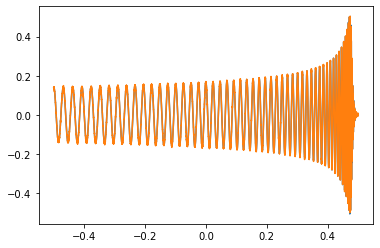

In [152]:
plt.plot(X_scaled, y_scaled)
plt.plot(X_scaled, model(X_scaled))

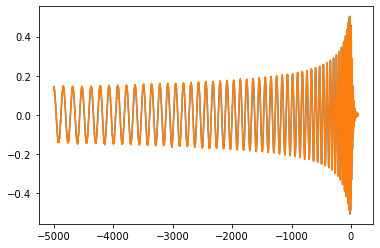

In [153]:
plt.plot(X, y_scaled)
plt.plot(X, model(X_scaled))

(-1000.0, 120.0)

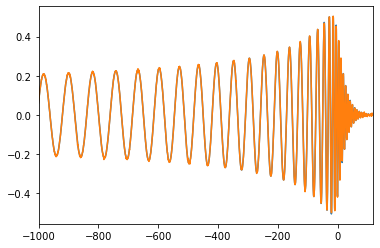

In [154]:
plt.plot(X, y_scaled)
plt.plot(X, model(X_scaled))
plt.xlim(-1000,120)

(-100.0, 120.0)

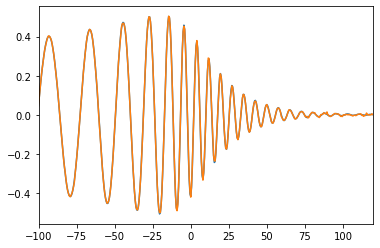

In [155]:
plt.plot(X, y_scaled)
plt.plot(X, model(X_scaled))
plt.xlim(-100, 120)

(-100.0, 120.0)

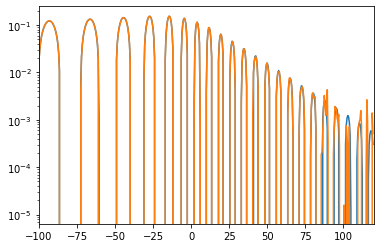

In [156]:
plt.plot(X, y)
plt.plot(X, y_scaler.inverse_transform(model(X_scaled)))
plt.yscale('log')
plt.xlim(-100, 120)

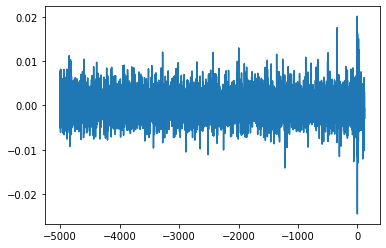

In [157]:
plt.plot(X, y_scaled-model(X_scaled))


In [158]:
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower

In [159]:
def compute_match(total_mass=100):
    
    t1=-5000
    t2=120
    dt=0.1
    times_M = np.arange(t1, t2, dt)[:,np.newaxis]

    data = utils.generate_waveform(times_M, mass_ratio=4, spin1z=0.99, f_lower=10, total_mass=total_mass, approximant="SEOBNRv4_opt")
    hp = data['hp'][:,0]
    

    delta_t = utils.MtoS(dt, total_mass)

    
    yhat = model(X_scaler.transform(times_M))
    yhat = y_scaler.inverse_transform(yhat)[:,0]
    
    hp1 = pycbc.types.TimeSeries(hp, delta_t=delta_t, dtype='float64')
    hp2 = pycbc.types.TimeSeries(yhat, delta_t=delta_t, dtype='float64')
    
    hp1_fs = hp1.to_frequencyseries()
    hp2_fs = hp2.to_frequencyseries()
    plt.plot(hp1_fs.sample_frequencies, np.abs(hp1_fs), label='data')
    plt.plot(hp2_fs.sample_frequencies, np.abs(hp2_fs), ls='--', label='model')
    plt.yscale('log')
    plt.xscale('log')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    f_low = 20
    
    # Resize the waveforms to the same length
    tlen = max(len(hp1), len(hp2))
    hp1.resize(tlen)
    hp2.resize(tlen)
    # Generate the aLIGO ZDHP PSD
    delta_f = 1.0 / hp1.duration
    flen = tlen//2 + 1
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    # Note: This takes a while the first time as an FFT plan is generated
    # subsequent calls are much faster.
    m, i = match(hp1, hp2, psd=psd, low_frequency_cutoff=f_low)
    # print(f'The match is: {m}')

    return m

0.9994791758747231

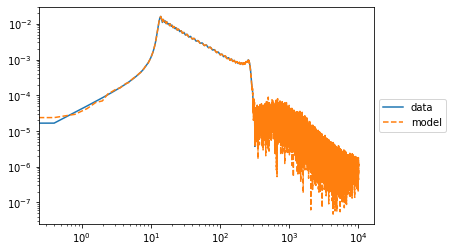

In [160]:
compute_match(total_mass=100)